# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

## Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries
import yfinance
import scipy.stats
# Import local libraries


# Data import
We retrieve all the required data for the analysis.

# CSI300 index

In [3]:
first = pd.read_csv('INDEX.CSI300_120101_141231.csv', delimiter = ",")
second = pd.read_csv('INDEX.CSI300_150101_171231.csv', delimiter = ",")
third = pd.read_csv('INDEX.CSI300_180101_201231.csv', delimiter = ",")
fourth = pd.read_csv('INDEX.CSI300_210101_221128.csv', delimiter = ",")

In [4]:
data = pd.DataFrame()
for i in [first, second, third, fourth]:
    data = data.append(i, ignore_index = True)
display(data)

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,INDEX.CSI300,5,20120104,54500,2361.4990,2361.4990,2361.4990,2361.4990,245403
1,INDEX.CSI300,5,20120104,55000,2363.8790,2364.2060,2355.8910,2355.8910,2013863
2,INDEX.CSI300,5,20120104,55500,2355.7500,2358.2700,2355.3040,2358.0250,1148331
3,INDEX.CSI300,5,20120104,60000,2358.4710,2365.8240,2358.2800,2363.9270,1411218
4,INDEX.CSI300,5,20120104,60500,2364.4720,2365.9150,2361.3150,2361.3150,1345723
...,...,...,...,...,...,...,...,...,...
155829,INDEX.CSI300,5,20221128,105000,3733.2424,3733.2424,3733.2424,3733.2424,60
155830,INDEX.CSI300,5,20221128,105500,3733.2424,3733.2424,3733.2424,3733.2424,59
155831,INDEX.CSI300,5,20221128,110000,3733.2424,3733.2424,3733.2424,3733.2424,59
155832,INDEX.CSI300,5,20221128,110500,3733.2424,3733.2424,3733.2424,3733.2424,56


In [5]:
del first
del second
del third
del fourth

In [6]:
import datetime
def time_and_date (df):
    date = []
    only_date = []
    for row in df.iterrows():
        #print(row[1]['<TIME>'])
        date_obj = row[1]['<DATE>']
        time_obj = row[1]['<TIME>']
        #print((time_obj % 10000)//100)
        #days.append((date_obj % 10000) // 100)
        only_date.append(datetime.datetime(date_obj // 10000, (date_obj % 10000) // 100, date_obj % 100))
        date.append(datetime.datetime(date_obj // 10000, (date_obj % 10000) // 100, date_obj % 100, time_obj //10000, (time_obj % 10000)//100 ))
    df['Date'] = date
    df['Only_date'] = only_date

In [7]:
time_and_date(data)

In [8]:
data = data.drop(columns = [x for x in data.columns if x not in ['<CLOSE>', 'Date', 'Only_date']])
data = data.rename(columns = {'<CLOSE>': 'Close'})

In [9]:
data = data.drop(data.loc[data['Only_date'] > '2022-11-27'].index.to_list(), axis = 0)

In [10]:
display(data)

,Close,Date,Only_date
0,2361.4990,2012-01-04 05:45:00,2012-01-04
1,2355.8910,2012-01-04 05:50:00,2012-01-04
2,2358.0250,2012-01-04 05:55:00,2012-01-04
3,2363.9270,2012-01-04 06:00:00,2012-01-04
4,2361.3150,2012-01-04 06:05:00,2012-01-04
...,...,...,...
155765,3775.7764,2022-11-25 10:50:00,2022-11-25
155766,3775.7764,2022-11-25 10:55:00,2022-11-25
155767,3775.7764,2022-11-25 11:00:00,2022-11-25
155768,3775.7764,2022-11-25 11:05:00,2022-11-25


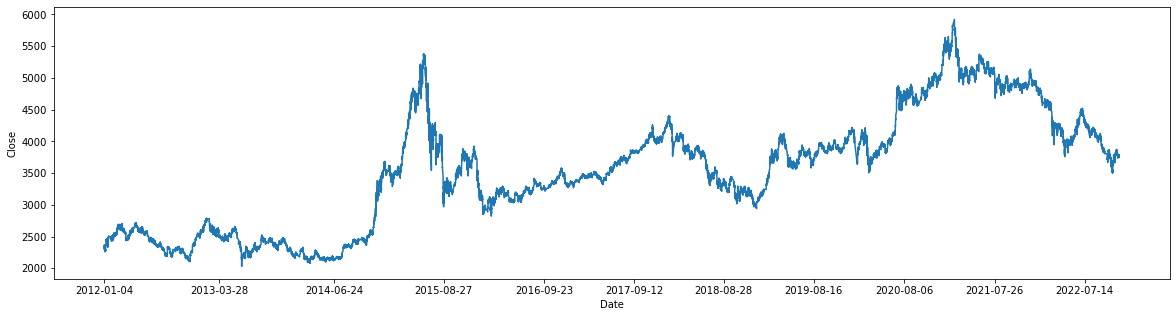

In [11]:
plt.figure(figsize = (20,5))
plt.plot(data['Date'], data['Close'])
plt.xticks(data['Date'][::15000])
plt.ylabel('Close')
plt.xlabel('Date')
plt.show()

# Data processing

In [12]:
#returns = data['Close'].pct_change().dropna()
returns = pd.DataFrame({
    'returns': data['Close'].pct_change().dropna(),
    'date': data['Date'][1:],
    'only_date': data['Only_date'][1:]
    
#    'rv': [x**2 for x in returns['returns']]
})
def realised_volatility(df):
    rv = []
    dates = []
    for date in df['only_date'].unique():
        _ = df.loc[df['only_date'] == date]
        rv.append(np.sum([x**2 for x in _['returns'].values]))
        dates.append(date)
    #= [x**2 for x in rv_per_day['returns']]
    new_df = pd.DataFrame({'rv': rv, 'date': dates})
    return new_df
returns['Ret_sqr'] = ((np.log(data.Close) - np.log(data.Close).shift(1))**2).dropna()
returns['for_BPV'] = (np.abs(returns.returns * returns.returns.shift(1))).dropna()
returns['for_RQ'] = (returns.returns ** 4).dropna()
BPV_data = returns.groupby('only_date')['for_BPV'].agg(np.sum).to_frame()
rv_per_day  = returns.groupby('only_date')["Ret_sqr"].agg(np.sum).to_frame()
RQ_data = returns.groupby('only_date')["for_RQ"].agg(np.sum).to_frame()
rv_per_day['BPV'] = BPV_data['for_BPV']
rv_per_day['RQ'] = RQ_data['for_RQ']
rv_per_day['M'] = [len(returns[returns['only_date'] == i ]) for i in returns.only_date.unique()]
rv_per_day.rename(columns = {"Ret_sqr": "rv_daily"}, inplace = True)
rv_per_day['date'] = returns.only_date.unique()

del data

In [13]:
display(rv_per_day)

,rv_daily,BPV,RQ,M,date
only_date,,,,,
2012-01-04,0.000088,0.000055,4.179587e-10,50,2012-01-04
2012-01-05,0.000177,0.000096,2.830245e-09,51,2012-01-05
2012-01-06,0.000149,0.000080,2.284259e-09,51,2012-01-06
2012-01-09,0.000297,0.000137,1.118065e-08,51,2012-01-09
2012-01-10,0.000175,0.000094,1.873278e-09,51,2012-01-10
...,...,...,...,...,...
2022-11-21,0.000148,0.000074,5.663656e-09,64,2022-11-21
2022-11-22,0.000105,0.000063,9.728191e-10,64,2022-11-22
2022-11-23,0.000128,0.000077,1.050754e-09,64,2022-11-23


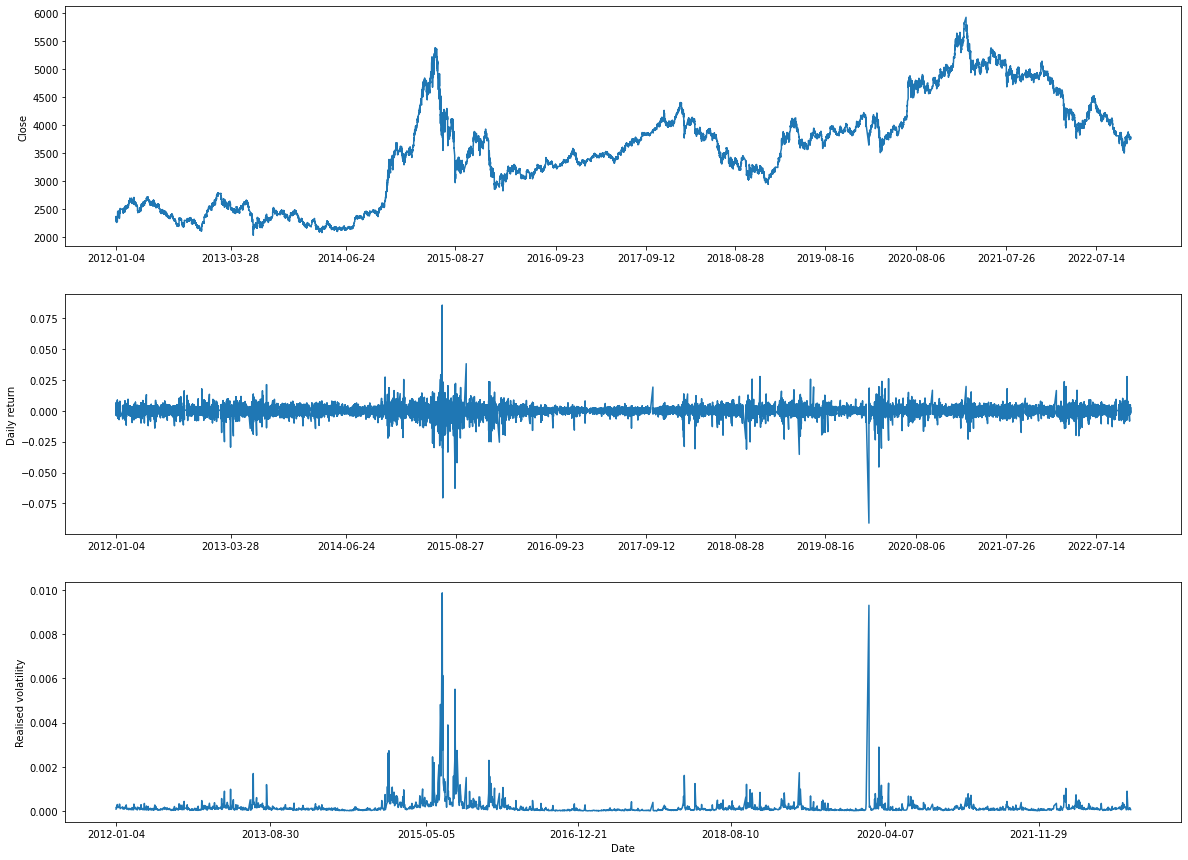

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))

ax[0].plot(data['Date'], data['Close'])
ax[0].set_xticks(data['Date'][::15000])
ax[0].set_ylabel('Close')
#ax.xlabel('Date')

ax[1].plot(returns['only_date'], returns['returns'])
ax[1].set_xticks(returns['only_date'][::15000])
ax[1].set_ylabel('Daily return')
#ax.xlabel('Date')

ax[2].plot(rv_per_day['date'], rv_per_day['rv_daily'])
ax[2].set_xticks(rv_per_day['date'][::400])
ax[2].set_ylabel('Realised volatility')
ax[2].set_xlabel('Date')



plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller
data_characteristics = pd.DataFrame()
i = 0
#print(np.quantile(returns['returns'], 0.01))
for ind, dat in enumerate([returns['returns'].values, rv_per_day['rv_daily'].values]):
    data_characteristics.loc[ind, 'mean'] = np.mean(dat)
    data_characteristics.loc[ind, 'var'] = np.var(dat)
    data_characteristics.loc[ind, 'skewness'] = scipy.stats.skew(dat)
    data_characteristics.loc[ind, 'kurtuosis'] = scipy.stats.kurtosis(dat)
    data_characteristics.loc[ind, 'Jarque-Bera'] = scipy.stats.jarque_bera(dat)[0]
    data_characteristics.loc[ind, 'ADF'] = adfuller(dat)[0]
    #print(adfuller(dat))
    #print(scipy.stats.jarque_bera(dat))


In [17]:
data_characteristics

,mean,var,skewness,kurtuosis,Jarque-Bera,ADF
0,0.000005,3.061411e-06,-1.566083,148.53049,1.432498e+08,-46.428630
1,0.000181,1.923947e-07,11.970899,201.95868,4.553104e+06,-5.554256


So, we can say that our data is not a stationary timeseries and don`t have normal distribution

# Models

In [19]:
def RV(df_rv, t, i):
    #print(t - datetime.timedelta(i))
    #print(df_rv.loc[df_rv['date'] == t - datetime.timedelta(days = i)]['rv'].values[0])
    if len(df_rv.loc[df_rv['date'] == t - datetime.timedelta(days=i)]['rv_daily'].values) != 0:
        return df_rv.loc[df_rv['date'] == t -
                         datetime.timedelta(days=i)]['rv_daily'].values[0]
    else:
        return 0
    #return df_rv.loc[df_rv['date'] == t - datetime.timedelta(days = i)]['rv'].values[0]  #[x**2 for x in df_r.loc[df_r['only_date'] == t - datetime.timedelta(i)]['returns'].values])


def RV_tj(df_rv, t, j, h):
    return (1 /
            (h + 1 - j)) * np.sum([RV(df_rv, t, i) for i in range(j, h + 1)])


def HAR(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind - 22, 'date'] = x[1]['date']
            HAR_data.loc[ind - 22, 'day'] = df_rv['rv_daily'][ind - 1]
            HAR_data.loc[ind - 22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind - 22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind - 22, 'rv'] = df_rv['rv_daily'][ind]
            #HAR_data.loc[ind,
            #             'cvartaly'] = np.sum(rv['returns'][ind - 66:ind]) / 66
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{round((ind+1)/df_rv.shape[0], 2)}')
            sys.stdout.flush()
    print()
    return HAR_data

def BPV(df_rv, t, i):
    l = (np.pi / 2) * df_rv.loc[df_rv['date'] == t - np.timedelta64(i, 'D')]['BPV'].values
    if len(l) == 0:
        return 0
    else:
        return l[0] 
    
def HAR_j(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            HAR_data.loc[ind - 22, 'date'] = x[1]['date']
            HAR_data.loc[ind - 22, 'day'] = df_rv['rv_daily'][ind - 1]
            HAR_data.loc[ind - 22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind - 22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind - 22, 'jump'] = max(0, df_rv['rv_daily'][ind-1] - BPV(df_rv, x[1]['date'], 1))
            HAR_data.loc[ind - 22, 'rv'] = df_rv['rv_daily'][ind]
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{round((ind+1)/df_rv.shape[0], 2)}')
            sys.stdout.flush()
    print()
    return HAR_data


#def BPV(df_r, t, i):
#    return (np.pi / 2) * np.sum([
#        df_r.iloc[row - 1]['returns'] * df_r.iloc[row]['returns']
#        for row in df_r.loc[df_r['only_date'] == t -
#                          datetime.timedelta(days=i)].index.to_list()[:-1]
#    ])

    #return (np.pi / 2) * df_BPV.loc[df_BPV['date'] == t - np.timedelta64(i, 'D')]['for_BPV'].values

def BPV_tj(df_rv, t, j, h):
    return (1 /
            (h - j + 1)) * np.sum([BPV(df_rv, t, i) for i in range(j, h + 1)])


def CHAR(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            #print(BPV(df_BPV, x[1]['date'], 1))
            HAR_data.loc[ind-22, 'day'] = BPV(df_rv, x[1]['date'], 1)
            HAR_data.loc[ind-22, 'week'] = BPV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = BPV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv_daily'][ind]
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{round((ind+1)/df_rv.shape[0], 2)}')
            sys.stdout.flush()
    print()
    return HAR_data


def SHAR(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            #print(x[1]['returns'])
            ret_positive = []
            ret_negative = []
            for ret in df_r.loc[df_r['only_date'] == df_rv.iloc[ind-1]['date']]['returns'].values:
                if ret > 0:
                    ret_positive.append(ret**2)
                else:
                    ret_negative.append(ret**2)
            HAR_data.loc[ind-22,
                         'day+'] = np.sum(ret_positive) / len(ret_positive)
            HAR_data.loc[ind-22,
                         'day-'] = np.sum(ret_negative) / len(ret_negative)
            
            HAR_data.loc[ind-22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv_daily'][ind]
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{round((ind+1)/df_rv.shape[0], 2)}')
            sys.stdout.flush()
    print()
    return HAR_data



def RQ(df_rv, t, i):
    #data = df_r.loc[df_r['only_date'] == t -
    #                datetime.timedelta(days=i)].reset_index(drop=True)
    #print(data)
    #print('  ')
    #print([(data['returns'][i]) ** 4 for i in range(data.shape[0])])
#    df_r['RQ'] = 
    l = (df_rv.loc[df_rv['date'] == t - np.timedelta64(i, 'D') ]['M'].values / 3 * df_rv.loc[df_rv['date'] == t - np.timedelta64(i, 'D') ]['RQ'].values)
    if len(l) == 0:
        return 0
    else:
        return l[0]
#(data.shape[0] / 3 * np.sum([(df_r['returns'][r-1])**4
#                                       for r in df_r.loc[df_r['only_date'] == t -
#                    datetime.timedelta(days=i)].index.to_list()[:-1]])) ** (1/2)


def HARQ(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            HAR_data.loc[ind-22, 'RQ^1/2'] = RQ(df_rv, x[1]['date'], 1) ** 0.5#* df_rv['rv'][ind - 1]
            HAR_data.loc[ind-22, 'day'] = df_rv['rv_daily'][ind - 1]
            HAR_data.loc[ind-22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv_daily'][ind]
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{round((ind+1)/df_rv.shape[0], 2)}')
            sys.stdout.flush()
    print()
    return HAR_data


def RQ_tj(df_rv, t, j, h):
    return (1 /
            (h + 1 - j)) * np.sum([RQ(df_rv, t, i) for i in range(j, h + 1)])


def HARQF(df_r, df_rv):
    HAR_data = pd.DataFrame()
    for ind, x in enumerate(df_rv.iterrows()):
        if ind > 21:
            #print(x[1]['date'])
            HAR_data.loc[ind-22, 'date'] = x[1]['date']
            HAR_data.loc[ind-22, 'day'] = df_rv['rv_daily'][ind - 1]
            HAR_data.loc[ind-22, 'day_RQ^1/2'] = (RQ(df_rv, x[1]['date'],
                                             1) ** 0.5) * df_rv['rv_daily'][ind - 1]
            HAR_data.loc[ind-22, 'week'] = RV_tj(df_rv, x[1]['date'], 1, 5) ** 0.5 
            HAR_data.loc[ind-22, 'week_RQ^1/2'] = (RQ_tj(
                df_rv, x[1]['date'], 1, 5) ** 0.5) * RV_tj(df_rv, x[1]['date'], 1, 5)
            HAR_data.loc[ind-22, 'month'] = RV_tj(df_rv, x[1]['date'], 1, 22) ** 0.5
            HAR_data.loc[ind-22, 'month_RQ^1/2'] = (RQ_tj(
                df_rv, x[1]['date'], 1, 22) ** 0.5) * RV_tj(df_rv, x[1]['date'], 1, 22)
            HAR_data.loc[ind-22, 'rv'] = df_rv['rv_daily'][ind]
            sys.stdout.write('\r' + ' ' * 50 + '\r')  # Очищение строки
            sys.stdout.write(f'{round((ind+1)/df_rv.shape[0], 2)}')
            sys.stdout.flush()
    print()
    return HAR_data

In [26]:
df_HAR = HAR(returns, rv_per_day)
print('HAR ready')
df_HAR_j = HAR_j(returns, rv_per_day)
print('HAR_j ready')
df_CHAR = CHAR(returns, rv_per_day)
print('CHAR ready')
df_SHAR = SHAR(returns, rv_per_day)
print('SHAR ready')
df_HARQ = HARQ(returns, rv_per_day)
print('HARQ ready')
df_HARQF = HARQF(returns, rv_per_day)
print('HARQF ready')

1.0                                               
HAR ready
1.0                                               
HAR_j ready
1.0                                               
CHAR ready
1.0                                               
SHAR ready
1.0                                               
HARQ ready
1.0                                               
HARQF ready


# Try models

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

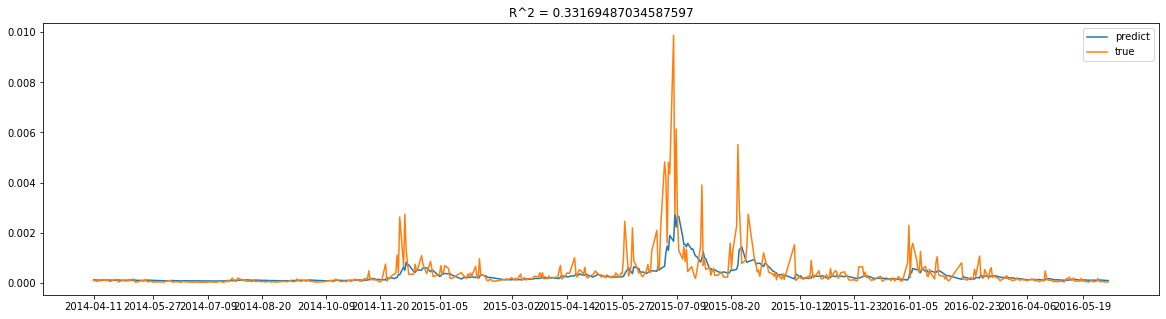

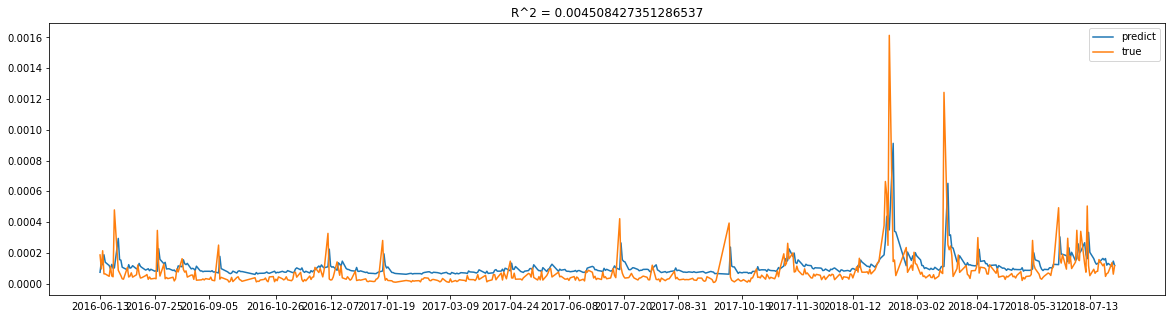

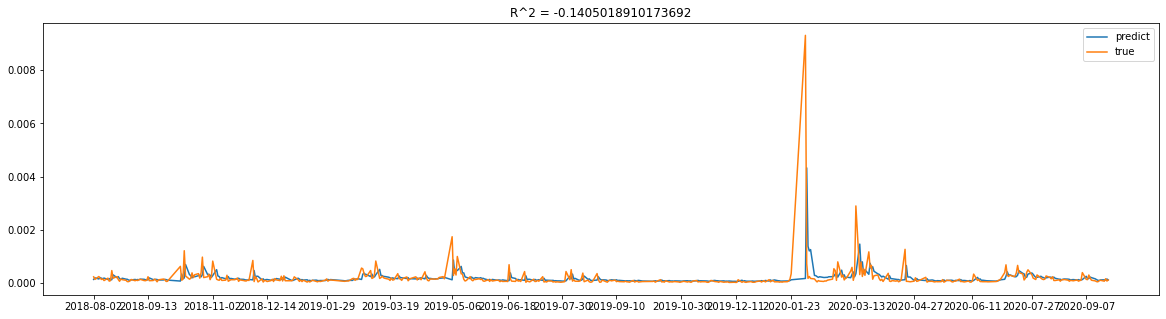

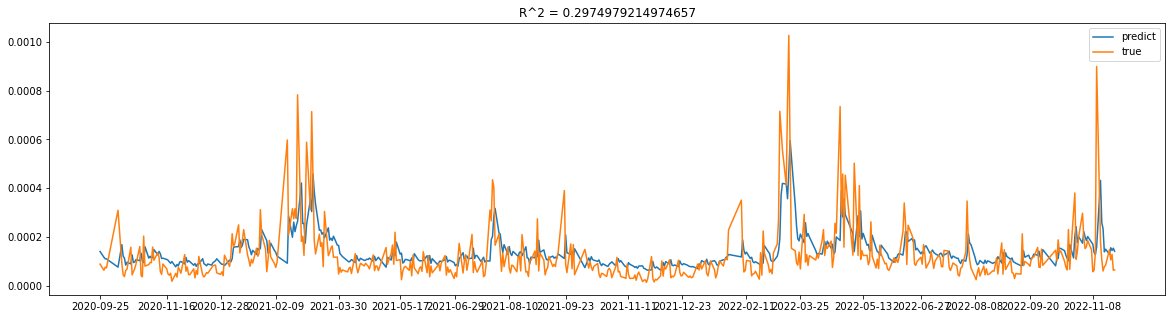

In [30]:
df = df_HAR
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()


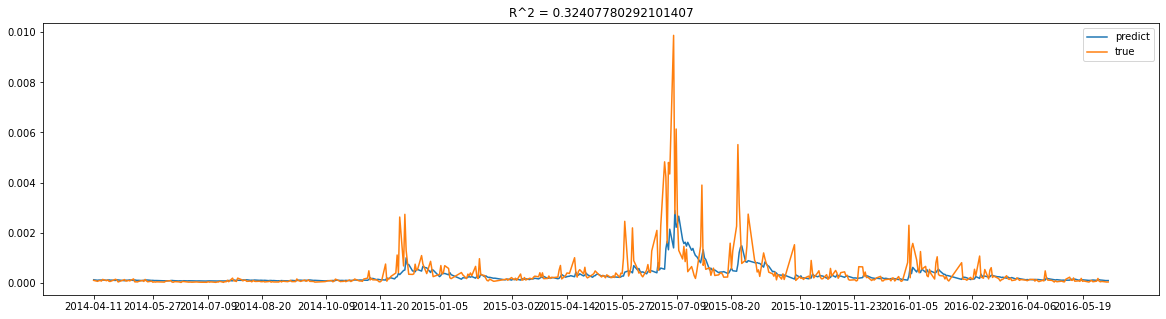

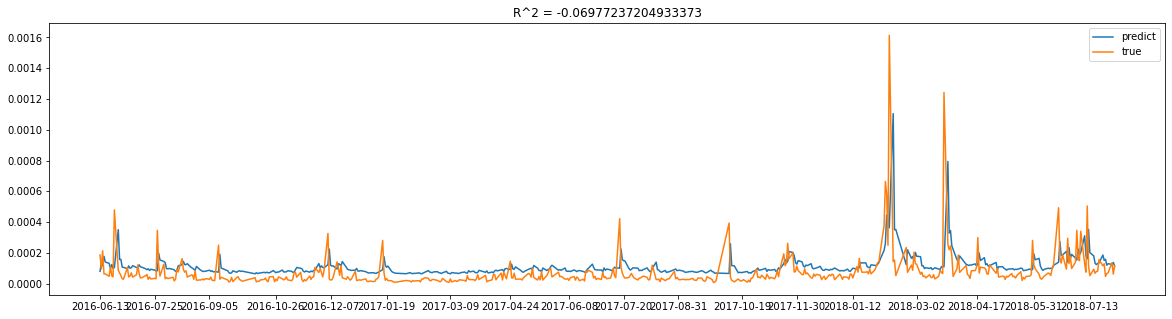

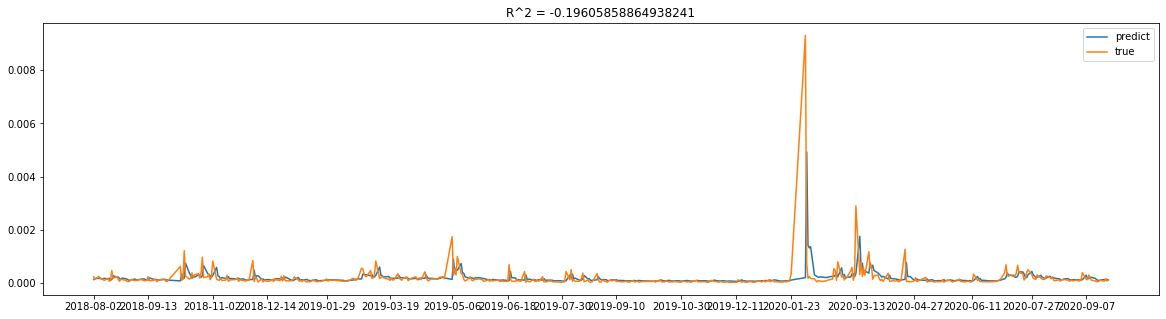

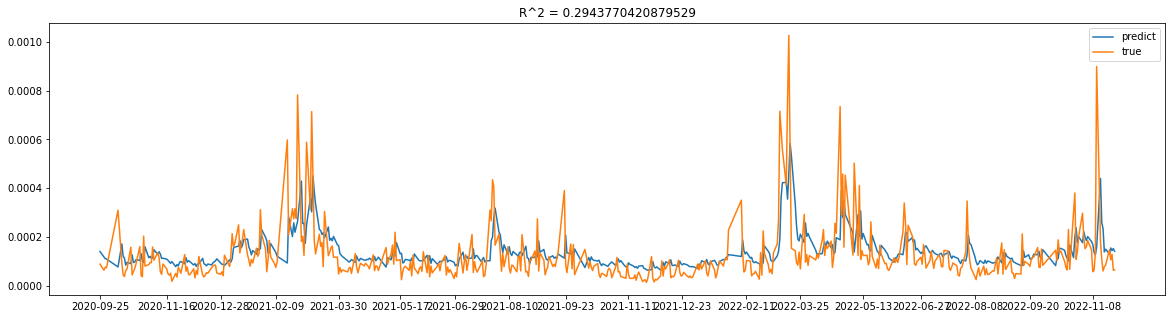

In [31]:
#df = HAR_j(returns, rv_per_day)
df = df_HAR_j
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()


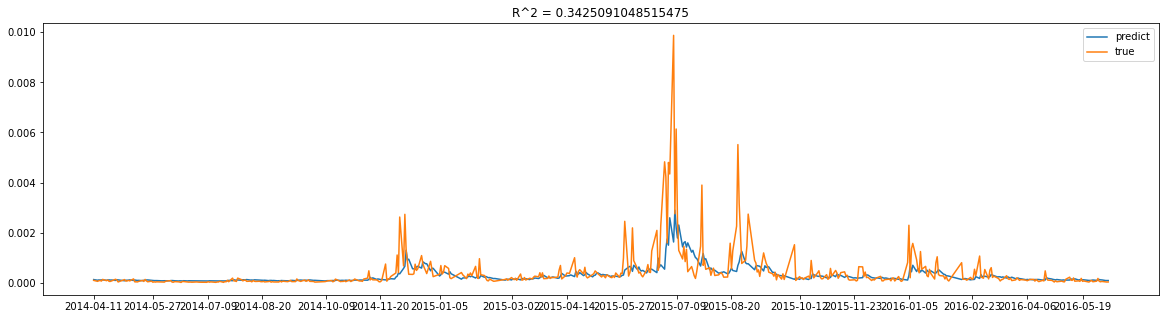

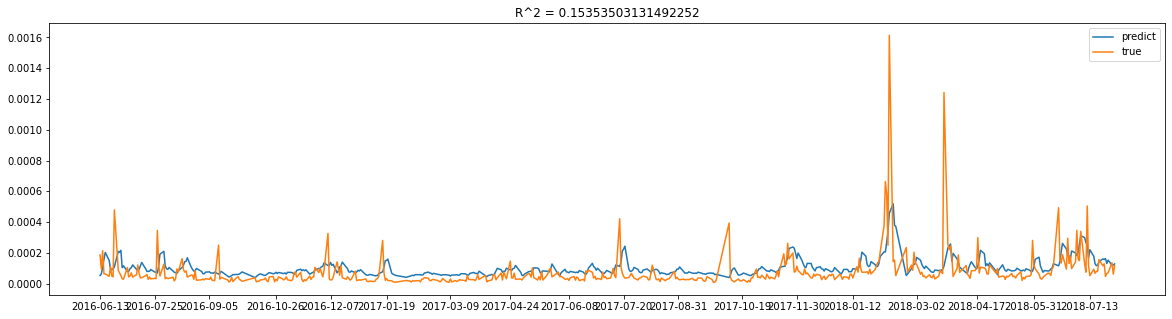

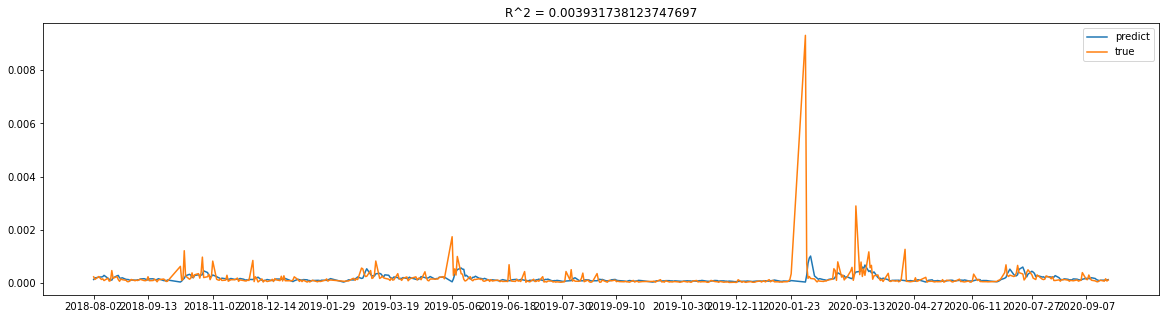

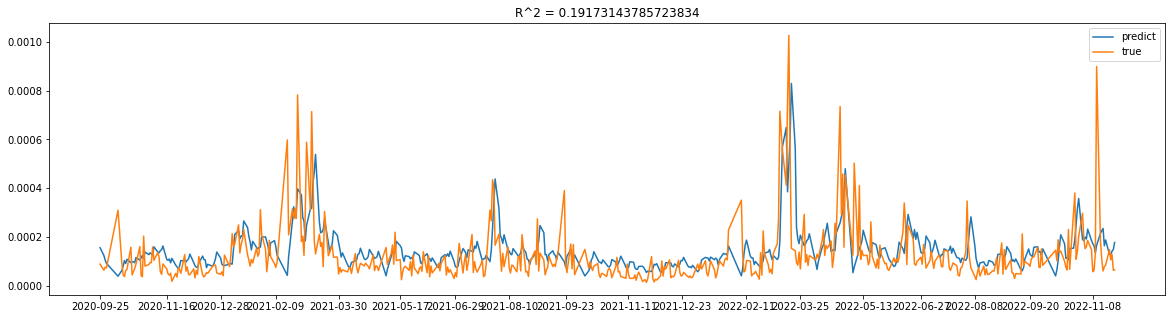

In [33]:
#df = CHAR(returns, rv_per_day, BPV_data)
df = df_CHAR
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    coefficents = {}
    coef = reg.coef_[0]
    #for ind, x in enumerate([x for x in coef]):
    #    coefficents[features[ind]] = x
    #display(coefficents)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

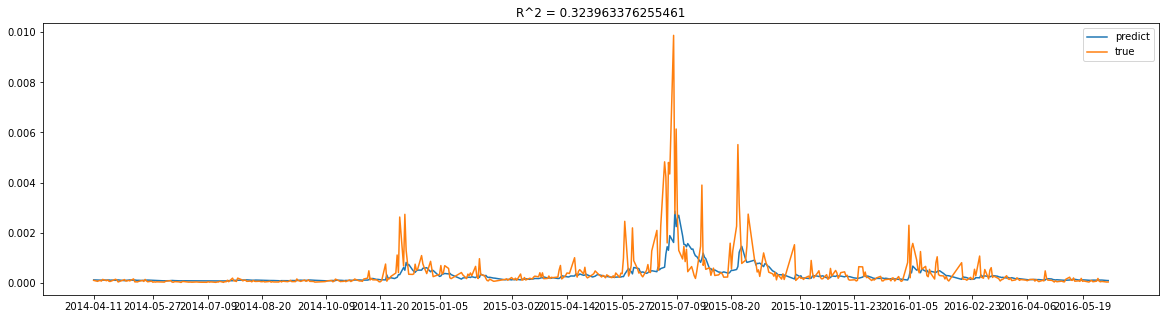

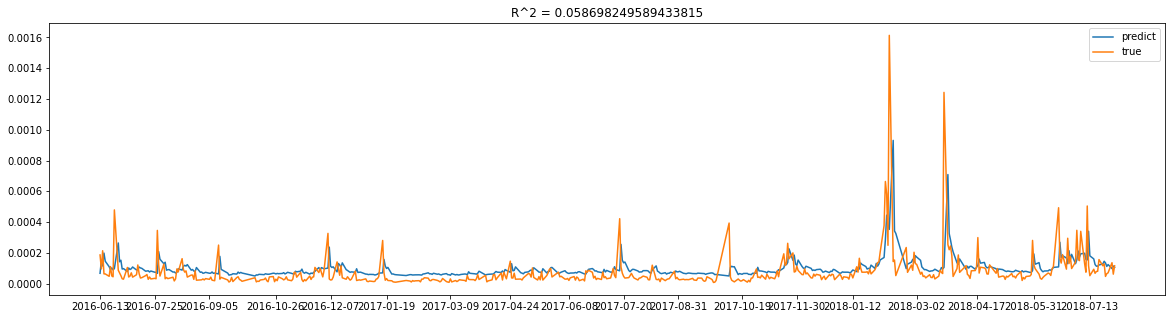

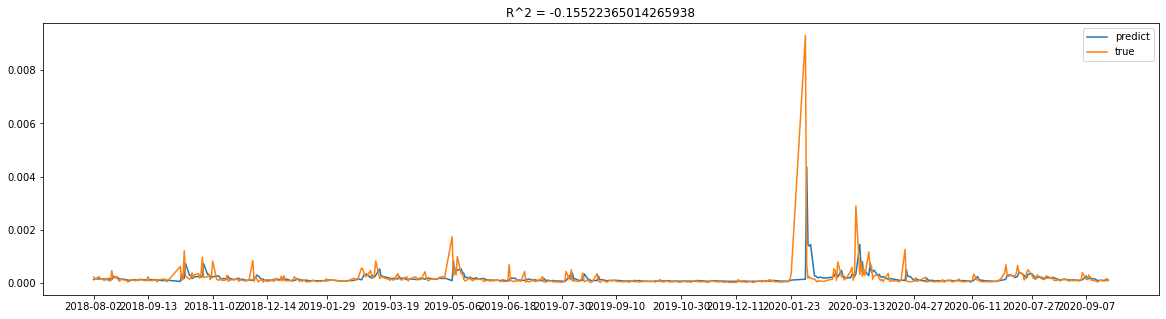

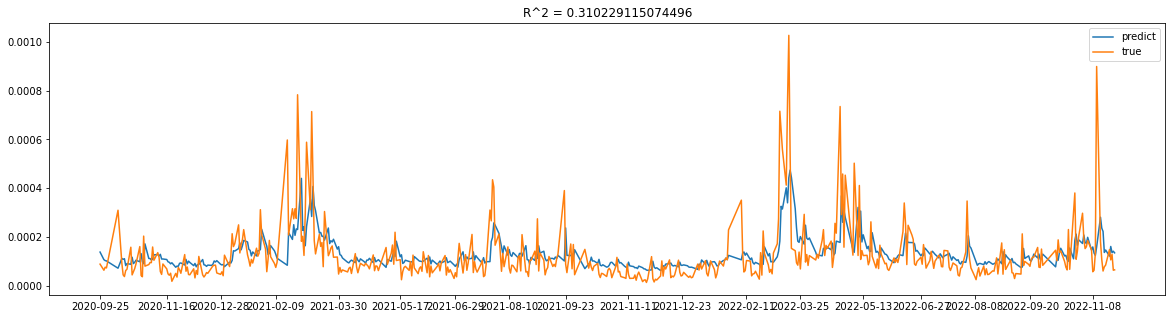

In [34]:
#df = SHAR(returns, rv_per_day)
df = df_SHAR
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

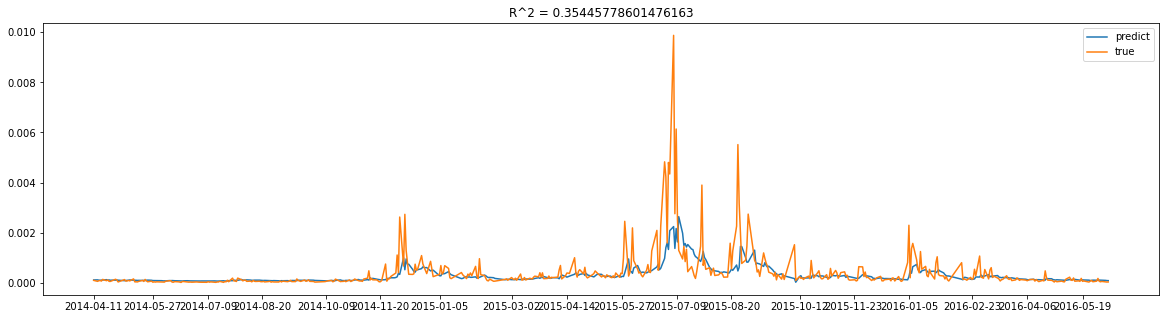

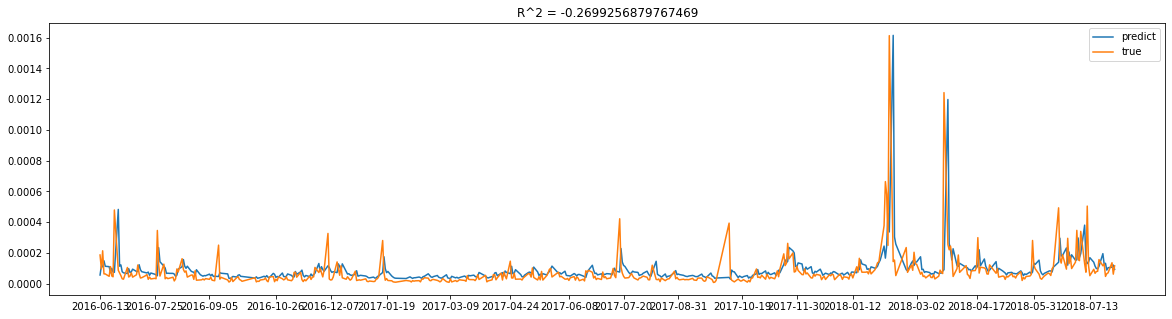

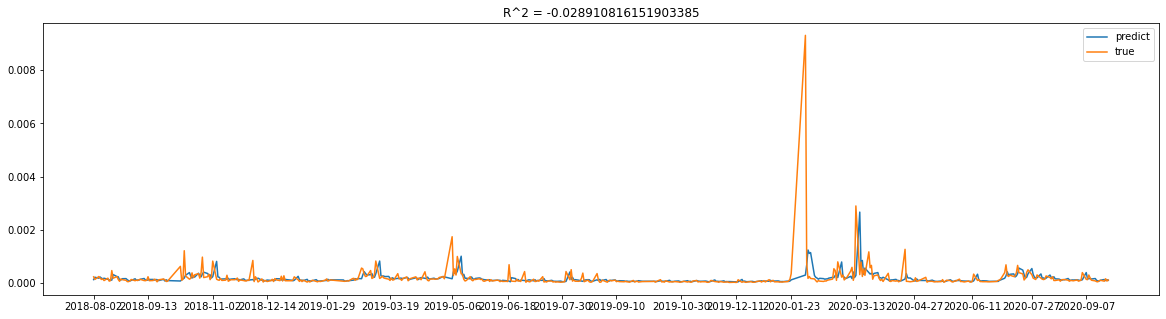

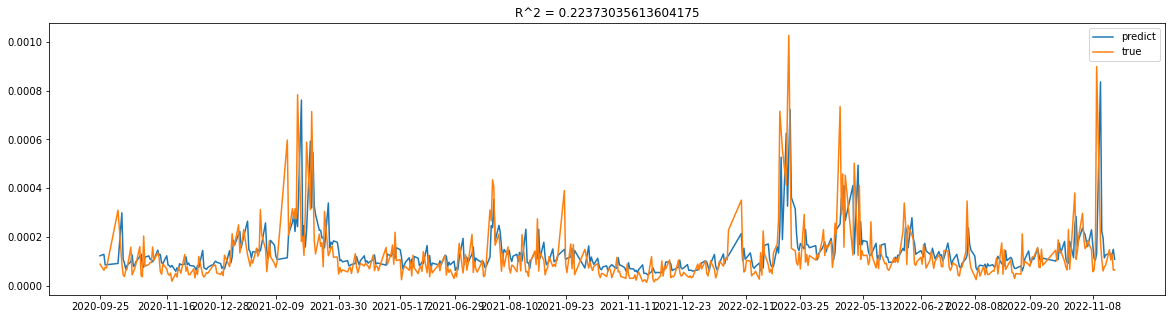

In [35]:
#df = HARQ(returns, rv_per_day, RQ_data)
df = df_HARQ
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

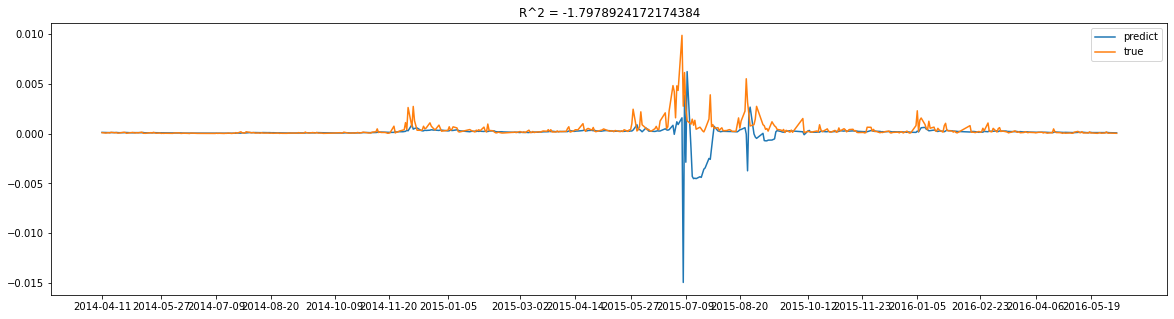

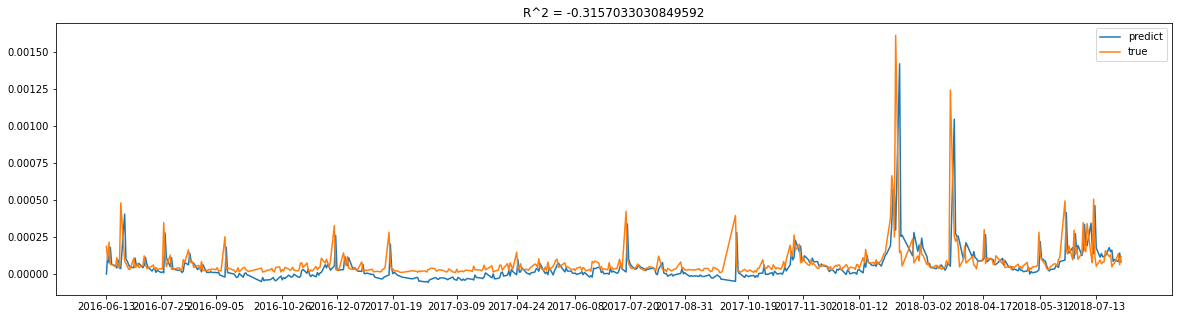

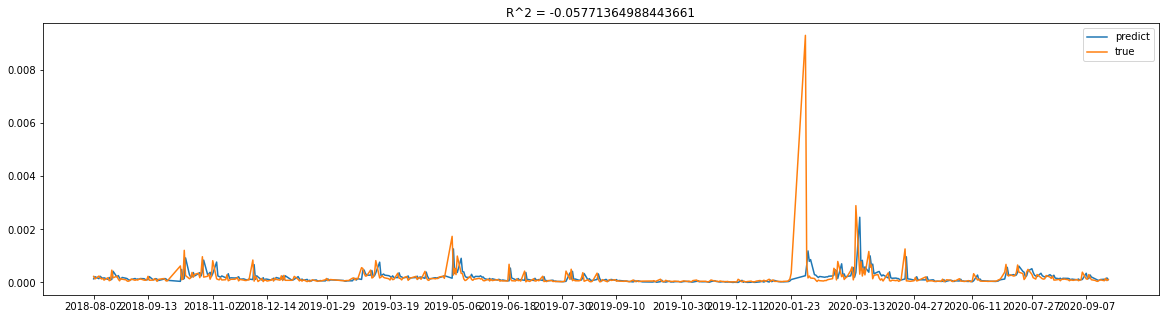

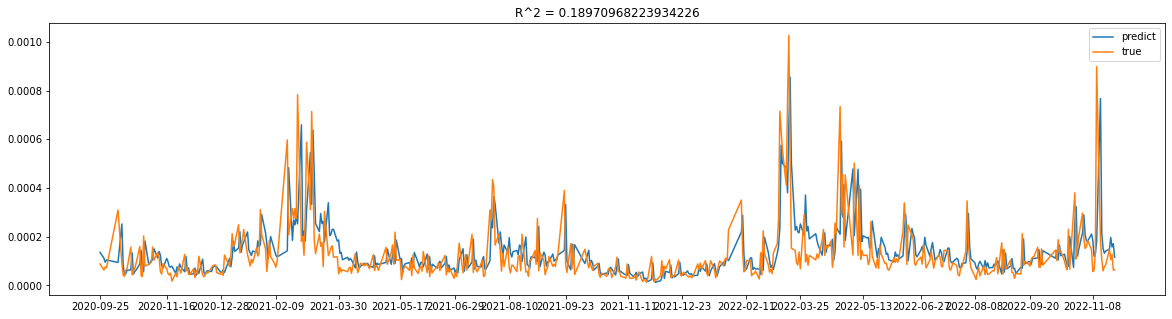

In [37]:
#df = HARQF(returns, rv_per_day)
df = df_HARQF
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
#print(features)
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    reg = LinearRegression().fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()

# All models in one & train set - $\frac{9}{10}$ of all data

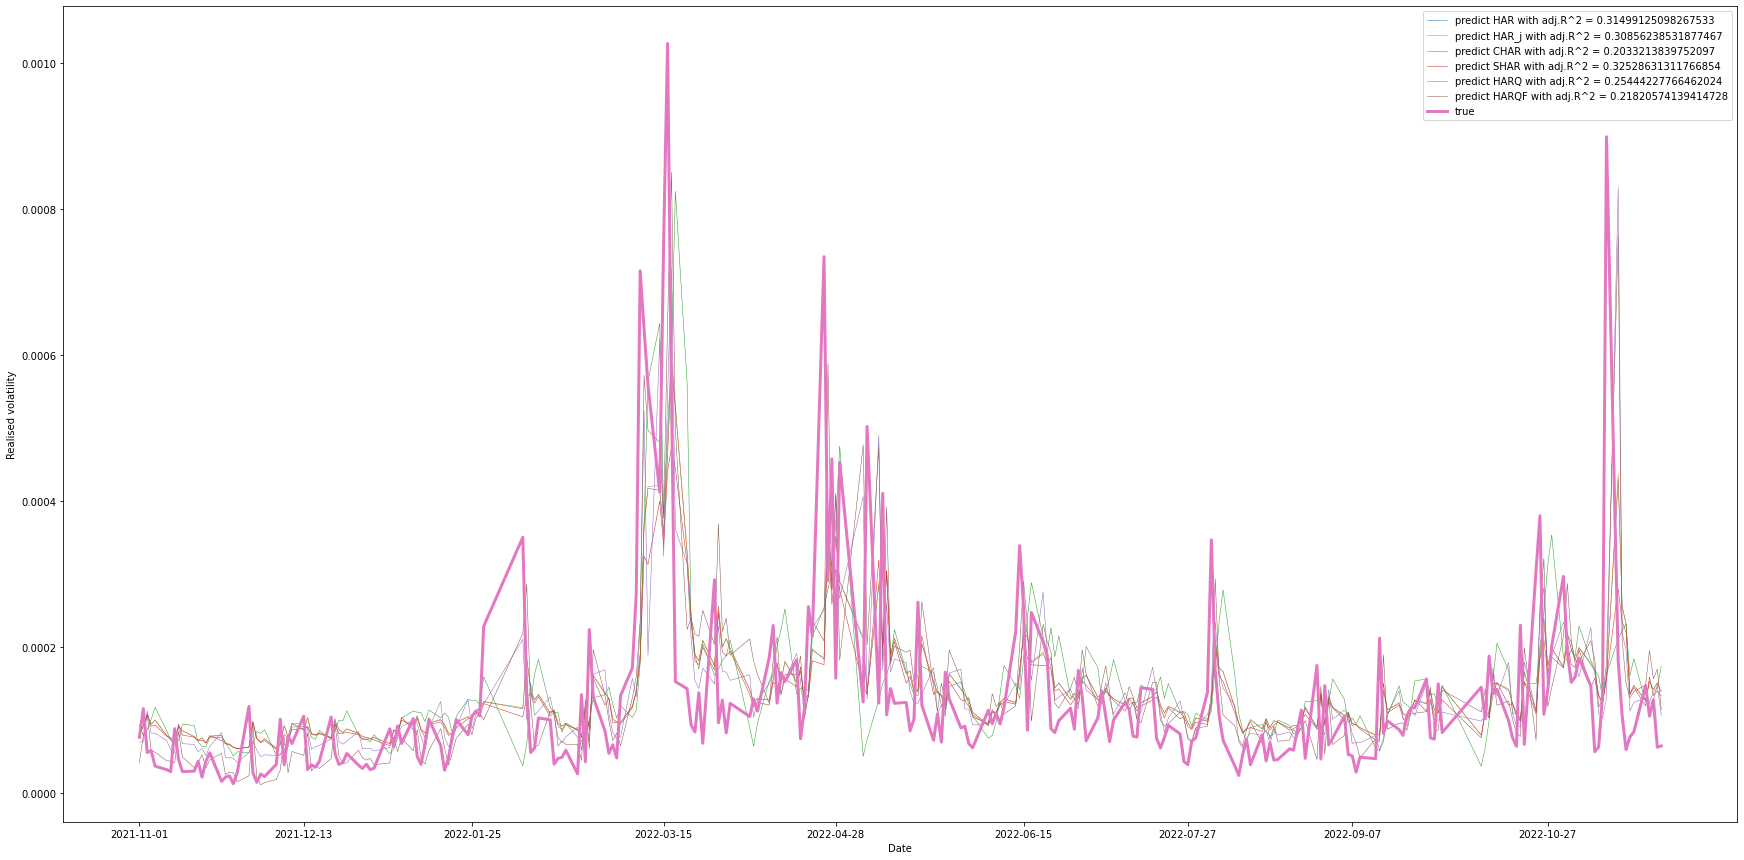

In [38]:
i = 0
names = ['HAR', 'HAR_j', 'CHAR', 'SHAR', 'HARQ', 'HARQF']
df_coefficients = pd.DataFrame()
fig = plt.figure(figsize=(30, 15))
for df in [df_HAR, df_HAR_j, df_CHAR, df_SHAR, df_HARQ, df_HARQF]: #[x(returns, rv_per_day) for x in [HAR, HAR_j, CHAR, SHAR, HARQ]]:#, HARQF]]:
    features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
    target = ['rv']
    #tscv = TimeSeriesSplit(n_splits = 4)
    #for train_index, test_index in tscv.split(df):
    #cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    param = 9 * df.shape[0]//10
    X_train = df[features][:param]
    y_train = df[target][:param]
    X_test = df[features][param:]
    y_test = df[target][param:]
    #print(df.shape, X_train.shape, X_test.shape)
    reg = LinearRegression().fit(X_train, y_train)
    
    coefficents = {}
    coef = reg.coef_[0]
    for ind, x in enumerate([x for x in coef]):
        coefficents[features[ind]] = x
    #display(coefficents)
    df_coefficients = df_coefficients.append(coefficents, ignore_index = True)
    
    plt.plot(df['date'][param:],reg.predict(X_test),
             label = 'predict ' + names[i] + ' with adj.R^2 = ' + str(1 - ((1 - r2_score(y_test, reg.predict(X_test))) * (y_test.shape[0] -1) / (y_test.shape[0] - len(features) -1))),
            linewidth = 0.5)
    if (i == 5):
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    
        #ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
        plt.plot(df['date'][param:],y_test, label = 'true', linewidth = 3, fillstyle = 'bottom')
        
        #plt.fill_between (df['date'][param:], y_test, color='black', alpha= .3 )
        plt.xticks(df['date'][param:][::30])
        plt.legend(prop={'size': 10})
        plt.xlabel('Date')
        plt.ylabel('Realised volatility')
        plt.show()
    i +=1
    

In [43]:
df_coefficients[-1:]['day_RQ^1/2'] = df_coefficients[-1:]['day_RQ^1/2']/ df_coefficients[-1:]['day']
df_coefficients[-1:]['week_RQ^1/2'] = df_coefficients[-1:]['week_RQ^1/2']/ df_coefficients[-1:]['week']
df_coefficients[-1:]['month_RQ^1/2'] = df_coefficients[-1:]['month_RQ^1/2']/ df_coefficients[-1:]['month']
df_coefficients = df_coefficients[['day', 'month', 'week', 'jump', 'day+', 'day-', 'RQ^1/2',
       'day_RQ^1/2', 'week_RQ^1/2', 'month_RQ^1/2']]
df_coefficients.index = names
df_coefficients.apply(lambda x: x.fillna(' '))

,day,month,week,jump,day+,day-,RQ^1/2,day_RQ^1/2,week_RQ^1/2,month_RQ^1/2
HAR,0.260248,0.334283,0.465342,,,,,,,
HAR_j,0.245002,0.335439,0.472933,0.021356,,,,,,
CHAR,-0.172697,0.174208,1.799946,,,,,,,
SHAR,,0.321202,0.456081,,1.78434,13.599659,,,,
HARQ,0.775595,0.194636,0.350506,,,,-0.185995,,,
HARQF,0.770444,0.014869,-0.004194,,,,,-32.174623,669081.641367,-56664.936557


In [45]:
import statsmodels.api as sm

In [60]:
df = df_HARQF
features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
#print(features)
target = ['rv']
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    X_train = cv_train[features]
    y_train = cv_train[target]
    X_test = cv_test[features]
    y_test = cv_test[target]
    X_train = sm.add_constant(X_train)
    reg = sm.OLS(y_train, X_train).fit()
    #print(reg.summary())
    #print(dict(reg.params))
    '''
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(cv_test['date'],reg.predict(X_test), label = 'predict')
    ax.plot(cv_test['date'],y_test, label = 'true')
    ax.set_xticks(cv_test['date'][::30])
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    ax.legend()
    plt.show()'''

{'const': -4.8262441766336545e-05, 'day': 0.2065623447052951, 'day_RQ^1/2': -71.00242417479396, 'week': 0.00039547531007653395, 'week_RQ^1/2': 147.89269979909818, 'month': 0.017105462664002376, 'month_RQ^1/2': -283.91428885895465}
{'const': -0.0001124615102637621, 'day': 0.7916199140287095, 'day_RQ^1/2': -20.713588735764496, 'week': 0.0021428056981661085, 'week_RQ^1/2': 11.923530099126232, 'month': 0.014057596196288186, 'month_RQ^1/2': -18.169433052153995}
{'const': -8.60833342785542e-05, 'day': 0.773110359756084, 'day_RQ^1/2': -20.13481954743298, 'week': 0.0016733010531943347, 'week_RQ^1/2': 12.819896812242561, 'month': 0.012853138458026301, 'month_RQ^1/2': -14.616616384156945}
{'const': -5.556047095527292e-05, 'day': 0.7728501576711955, 'day_RQ^1/2': -19.163591220838963, 'week': -0.00407538486610623, 'week_RQ^1/2': 11.589006522825393, 'month': 0.01491835661203385, 'month_RQ^1/2': -12.99042616476449}


In [64]:
i = 0
names = ['HAR', 'HAR_j', 'CHAR', 'SHAR', 'HARQ', 'HARQF']
df_coefficients = pd.DataFrame()
fig = plt.figure(figsize=(30, 15))
for df in [df_HAR, df_HAR_j, df_CHAR, df_SHAR, df_HARQ, df_HARQF]: #[x(returns, rv_per_day) for x in [HAR, HAR_j, CHAR, SHAR, HARQ]]:#, HARQF]]:
    features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
    target = ['rv']
    param = df.shape[0]
    X_train = df[features][:param]
    y_train = df[target][:param]
    #X_train = sm.add_constant(X_train)
    reg = sm.OLS(y_train, X_train).fit()
    print('Result for ' + names[i])
    print()
    print(reg.summary())
    print()
    print()
    df_coefficients = df_coefficients.append(dict(reg.params), ignore_index = True)
    i += 1

Result for HAR

                                 OLS Regression Results                                
Dep. Variable:                     rv   R-squared (uncentered):                   0.442
Model:                            OLS   Adj. R-squared (uncentered):              0.441
Method:                 Least Squares   F-statistic:                              690.7
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:26:41   Log-Likelihood:                          17088.
No. Observations:                2620   AIC:                                 -3.417e+04
Df Residuals:                    2617   BIC:                                 -3.415e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

<Figure size 2160x1080 with 0 Axes>

In [65]:
df_coefficients

,day,month,week,jump,day+,day-,RQ^1/2,day_RQ^1/2,month_RQ^1/2,week_RQ^1/2
0,0.268361,0.414962,0.465845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.266699,0.415129,0.466675,0.00234,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.155457,0.258893,1.782568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.405282,0.462873,NaN,1.891166,13.77196,NaN,NaN,NaN,NaN
4,0.782439,0.241468,0.353494,NaN,NaN,NaN,-0.187694,NaN,NaN,NaN
5,0.801641,0.010106,-0.005397,NaN,NaN,NaN,NaN,-19.859946,-1.743487,12.045813


In [67]:
df_coefficients[-1:]['day_RQ^1/2'] = df_coefficients[-1:]['day_RQ^1/2']/ df_coefficients[-1:]['day']
df_coefficients[-1:]['week_RQ^1/2'] = df_coefficients[-1:]['week_RQ^1/2']/ df_coefficients[-1:]['week']
df_coefficients[-1:]['month_RQ^1/2'] = df_coefficients[-1:]['month_RQ^1/2']/ df_coefficients[-1:]['month']
df_coefficients = df_coefficients[['day', 'month', 'week', 'jump', 'day+', 'day-', 'RQ^1/2',
       'day_RQ^1/2', 'week_RQ^1/2', 'month_RQ^1/2']]
df_coefficients.index = names
df_coefficients = df_coefficients.apply(lambda x: x.fillna(' '))

In [74]:
df_coefficients['R^2_adj'] = [0.441, 0.441, 0.480, 0.453, 0.501, 0.487]
display(df_coefficients)

,day,month,week,jump,day+,day-,RQ^1/2,day_RQ^1/2,week_RQ^1/2,month_RQ^1/2,R^2_adj
HAR,0.268361,0.414962,0.465845,,,,,,,,0.441
HAR_j,0.266699,0.415129,0.466675,0.00234,,,,,,,0.441
CHAR,-0.155457,0.258893,1.782568,,,,,,,,0.480
SHAR,,0.405282,0.462873,,1.891166,13.77196,,,,,0.453
HARQ,0.782439,0.241468,0.353494,,,,-0.187694,,,,0.501
HARQF,0.801641,0.010106,-0.005397,,,,,-30.904276,413508.799516,-17069.995668,0.487


# D&J index

In [11]:
first = pd.read_csv('D&J-IND_130101_141231.csv', delimiter = ",")
second = pd.read_csv('D&J-IND_150101_161231.csv', delimiter = ",")
third = pd.read_csv('D&J-IND_170101_191231.csv', delimiter = ",")
fourth = pd.read_csv('D&J-IND_200101_221128.csv', delimiter = ",")

In [12]:
data = pd.DataFrame()
for i in [first, second, third, fourth]:
    data = data.append(i, ignore_index = True)
display(data)

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,D&J-IND,5,20130101,500,13104.140000,13104.140000,13104.140000,13104.140000,0
1,D&J-IND,5,20130101,172000,13104.140000,13104.140000,13104.140000,13104.140000,0
2,D&J-IND,5,20130102,500,13104.140000,13104.140000,13104.140000,13104.140000,0
3,D&J-IND,5,20130102,93500,13104.300000,13325.580000,13104.300000,13325.580000,0
4,D&J-IND,5,20130102,94000,13325.690000,13339.820000,13325.690000,13334.490000,0
...,...,...,...,...,...,...,...,...,...
205825,D&J-IND,5,20221128,161000,33850.602927,33850.602927,33850.602927,33850.602927,300
205826,D&J-IND,5,20221128,161500,33850.602927,33850.602927,33850.602927,33850.602927,299
205827,D&J-IND,5,20221128,162000,33850.602927,33850.602927,33850.602927,33850.602927,300
205828,D&J-IND,5,20221128,162500,33850.602927,33850.602927,33850.602927,33850.602927,1


In [13]:
del first
del second
del third
del fourth

In [14]:
time_and_date(data)

In [15]:
data = data.drop(columns = [x for x in data.columns if x not in ['<CLOSE>', 'Date', 'Only_date']])
data = data.rename(columns = {'<CLOSE>': 'Close'})

In [16]:
#returns = data['Close'].pct_change().dropna()
returns = pd.DataFrame({
    'returns': data['Close'].pct_change().dropna(),
    'date': data['Date'][1:],
    'only_date': data['Only_date'][1:]
    
#    'rv': [x**2 for x in returns['returns']]
})
def realised_volatility(df):
    rv = []
    dates = []
    for date in df['only_date'].unique():
        _ = df.loc[df['only_date'] == date]
        rv.append(np.sum([x**2 for x in _['returns'].values]))
        dates.append(date)
    #= [x**2 for x in rv_per_day['returns']]
    new_df = pd.DataFrame({'rv': rv, 'date': dates})
    return new_df
returns['Ret_sqr'] = ((np.log(data.Close) - np.log(data.Close).shift(1))**2).dropna()
returns['for_BPV'] = (np.abs(returns.returns * returns.returns.shift(1))).dropna()
returns['for_RQ'] = (returns.returns ** 4).dropna()
BPV_data = returns.groupby('only_date')['for_BPV'].agg(np.sum).to_frame()
rv_per_day  = returns.groupby('only_date')["Ret_sqr"].agg(np.sum).to_frame()
RQ_data = returns.groupby('only_date')["for_RQ"].agg(np.sum).to_frame()
rv_per_day['BPV'] = BPV_data['for_BPV']
rv_per_day['RQ'] = RQ_data['for_RQ']
rv_per_day['M'] = [len(returns[returns['only_date'] == i ]) for i in returns.only_date.unique()]
rv_per_day.rename(columns = {"Ret_sqr": "rv_daily"}, inplace = True)
rv_per_day['date'] = returns.only_date.unique()


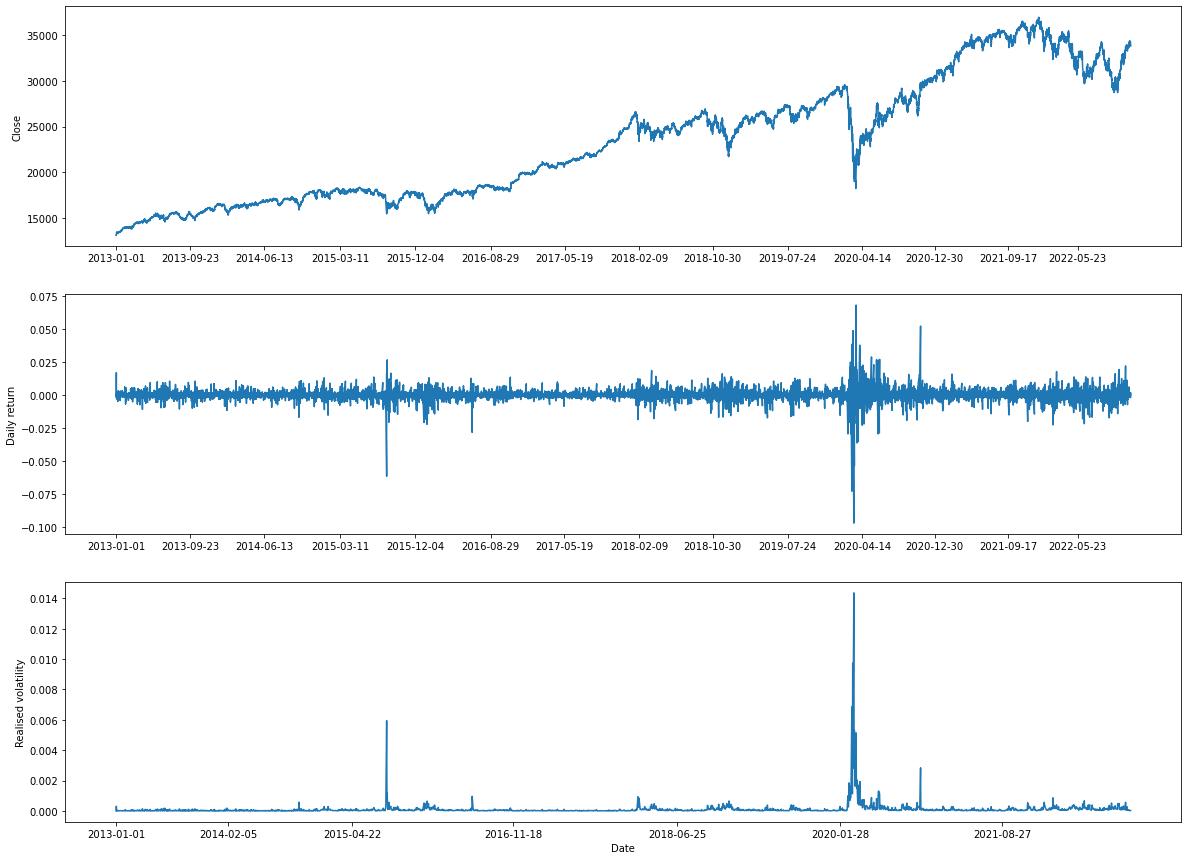

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))

ax[0].plot(data['Date'], data['Close'])
ax[0].set_xticks(data['Date'][::15000])
ax[0].set_ylabel('Close')
#ax.xlabel('Date')

ax[1].plot(returns['only_date'], returns['returns'])
ax[1].set_xticks(returns['only_date'][::15000])
ax[1].set_ylabel('Daily return')
#ax.xlabel('Date')

ax[2].plot(rv_per_day['date'], rv_per_day['rv_daily'])
ax[2].set_xticks(rv_per_day['date'][::400])
ax[2].set_ylabel('Realised volatility')
ax[2].set_xlabel('Date')



plt.show()

In [ ]:
del data

In [18]:
from statsmodels.tsa.stattools import adfuller
data_characteristics = pd.DataFrame()
i = 0
#print(np.quantile(returns['returns'], 0.01))
for ind, dat in enumerate([returns['returns'].values, rv_per_day['rv_daily'].values]):
    data_characteristics.loc[ind, 'mean'] = np.mean(dat)
    data_characteristics.loc[ind, 'var'] = np.var(dat)
    data_characteristics.loc[ind, 'skewness'] = scipy.stats.skew(dat)
    data_characteristics.loc[ind, 'kurtuosis'] = scipy.stats.kurtosis(dat)
    data_characteristics.loc[ind, 'Jarque-Bera'] = scipy.stats.jarque_bera(dat)[0]
    data_characteristics.loc[ind, 'ADF'] = adfuller(dat)[0]
    #print(adfuller(dat))
    #print(scipy.stats.jarque_bera(dat))
display(data_characteristics)

,mean,var,skewness,kurtuosis,Jarque-Bera,ADF
0,0.000005,1.381781e-06,-4.222766,595.302170,3.039889e+09,-48.544879
1,0.000105,2.042643e-07,19.266448,485.974396,2.689473e+07,-7.901002


In [20]:
df_HAR = HAR(returns, rv_per_day)
print('HAR ready')
df_HAR_j = HAR_j(returns, rv_per_day)
print('HAR_j ready')
df_CHAR = CHAR(returns, rv_per_day)
print('CHAR ready')
df_SHAR = SHAR(returns, rv_per_day)
print('SHAR ready')
df_HARQ = HARQ(returns, rv_per_day)
print('HARQ ready')
df_HARQF = HARQF(returns, rv_per_day)
print('HARQF ready')

1.0                                               
HAR ready
1.0                                               
HAR_j ready
1.0                                               
CHAR ready
1.0                                               
SHAR ready
1.0                                               
HARQ ready
1.0                                               
HARQF ready


In [21]:
import statsmodels.api as sm

In [28]:
i = 0
names = ['HAR', 'HAR_j', 'CHAR', 'SHAR', 'HARQ', 'HARQF']
df_coefficients = pd.DataFrame()
fig = plt.figure(figsize=(30, 15))
for df in [df_HAR, df_HAR_j, df_CHAR, df_SHAR, df_HARQ, df_HARQF]: #[x(returns, rv_per_day) for x in [HAR, HAR_j, CHAR, SHAR, HARQ]]:#, HARQF]]:
    features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
    target = ['rv']
    param = df.shape[0]
    X_train = df[features][:param]
    y_train = df[target][:param]
    #X_train = sm.add_constant(X_train)
    reg = sm.OLS(y_train, X_train).fit()
    print('Result for ' + names[i])
    print()
    print(reg.summary())
    print()
    print()
    df_coefficients = df_coefficients.append(dict(reg.params), ignore_index = True)
    i += 1

Result for HAR

                                 OLS Regression Results                                
Dep. Variable:                     rv   R-squared (uncentered):                   0.425
Model:                            OLS   Adj. R-squared (uncentered):              0.424
Method:                 Least Squares   F-statistic:                              663.2
Date:                Sun, 15 Jan 2023   Prob (F-statistic):                   9.88e-323
Time:                        13:53:11   Log-Likelihood:                          17590.
No. Observations:                2694   AIC:                                 -3.517e+04
Df Residuals:                    2691   BIC:                                 -3.516e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

<Figure size 2160x1080 with 0 Axes>

In [27]:
df_SHAR = df_SHAR.fillna(0)

In [29]:
df_coefficients[-1:]['day_RQ^1/2'] = df_coefficients[-1:]['day_RQ^1/2']/ df_coefficients[-1:]['day']
df_coefficients[-1:]['week_RQ^1/2'] = df_coefficients[-1:]['week_RQ^1/2']/ df_coefficients[-1:]['week']
df_coefficients[-1:]['month_RQ^1/2'] = df_coefficients[-1:]['month_RQ^1/2']/ df_coefficients[-1:]['month']
df_coefficients = df_coefficients[['day', 'month', 'week', 'jump', 'day+', 'day-', 'RQ^1/2',
       'day_RQ^1/2', 'week_RQ^1/2', 'month_RQ^1/2']]
df_coefficients.index = names
df_coefficients = df_coefficients.apply(lambda x: x.fillna(' '))

In [30]:
df_coefficients['R^2_adj'] = [0.424, 0.447, 0.437, 0.463, 0.568, 0.505]
display(df_coefficients)

,day,month,week,jump,day+,day-,RQ^1/2,day_RQ^1/2,week_RQ^1/2,month_RQ^1/2,R^2_adj
HAR,0.057076,0.238669,0.892634,,,,,,,,0.424
HAR_j,-0.552625,0.271578,1.111637,0.772656,,,,,,,0.447
CHAR,-0.416282,0.118918,2.778516,,,,,,,,0.437
SHAR,,0.081714,0.845265,,27.680583,-7.867986,,,,,0.463
HARQ,1.446652,0.098369,0.376444,,,,-0.363173,,,,0.568
HARQF,1.039842,0.002121,-0.000310,,,,,-22.325816,-65225.398722,-1908.917039,0.505


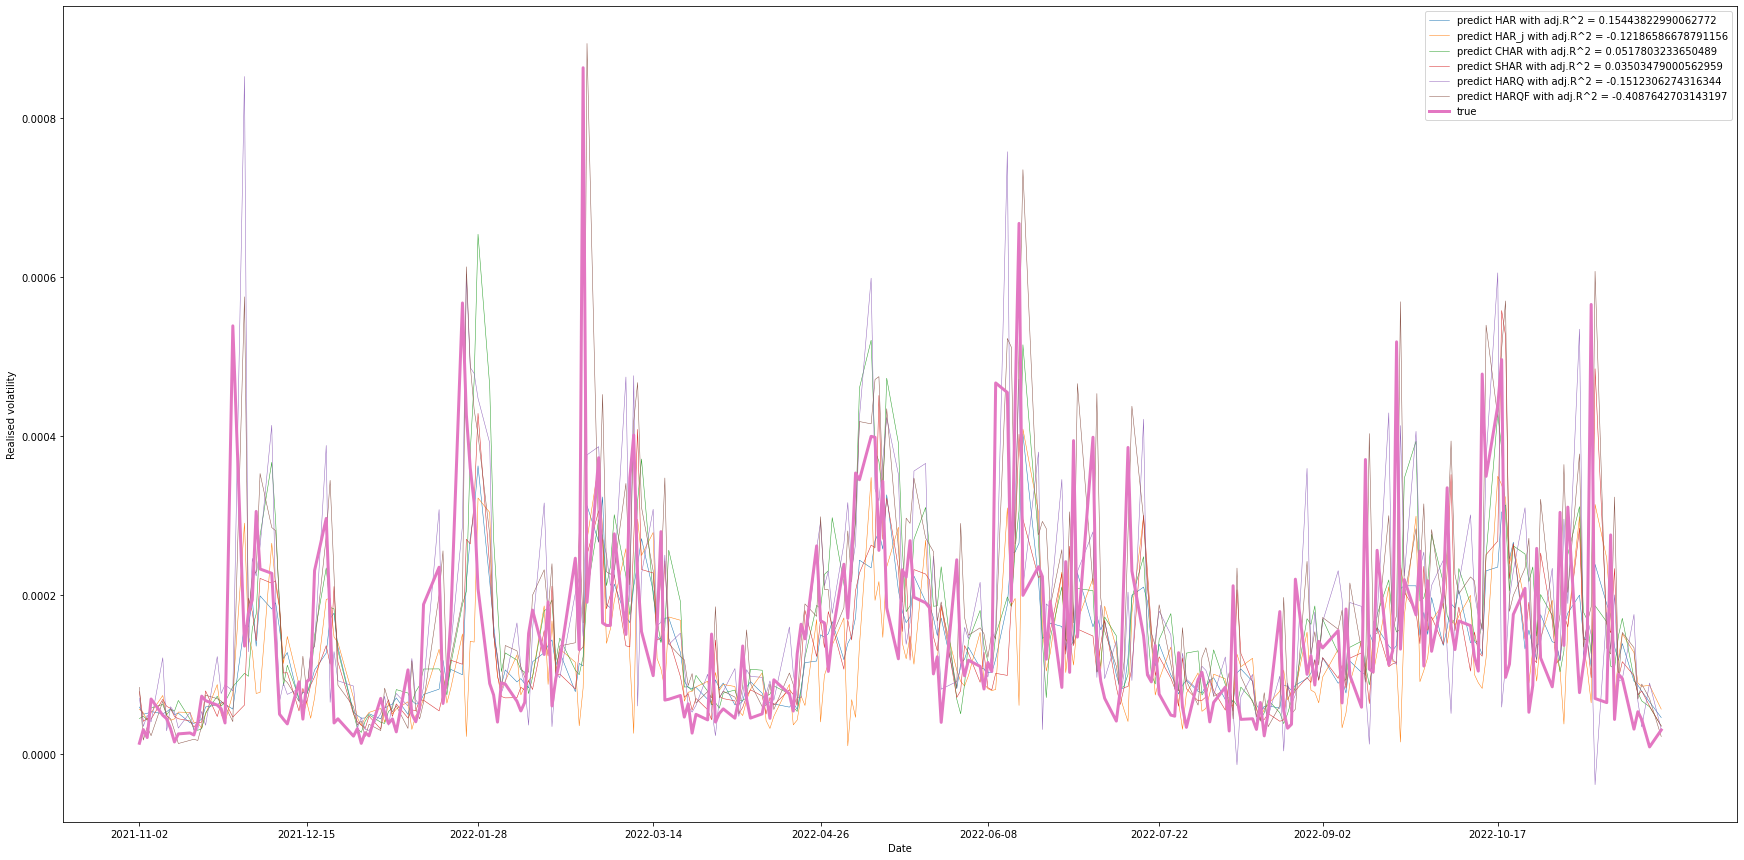

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
i = 0
names = ['HAR', 'HAR_j', 'CHAR', 'SHAR', 'HARQ', 'HARQF']
df_coefficients = pd.DataFrame()
fig = plt.figure(figsize=(30, 15))
for df in [df_HAR, df_HAR_j, df_CHAR, df_SHAR, df_HARQ, df_HARQF]: #[x(returns, rv_per_day) for x in [HAR, HAR_j, CHAR, SHAR, HARQ]]:#, HARQF]]:
    features = [x for x in df.columns if (x != 'rv') & (x != 'date')]
    target = ['rv']
    #tscv = TimeSeriesSplit(n_splits = 4)
    #for train_index, test_index in tscv.split(df):
    #cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    param = 9 * df.shape[0]//10
    X_train = df[features][:param]
    y_train = df[target][:param]
    X_test = df[features][param:]
    y_test = df[target][param:]
    #print(df.shape, X_train.shape, X_test.shape)
    reg = LinearRegression().fit(X_train, y_train)
    
    coefficents = {}
    coef = reg.coef_[0]
    for ind, x in enumerate([x for x in coef]):
        coefficents[features[ind]] = x
    #display(coefficents)
    df_coefficients = df_coefficients.append(coefficents, ignore_index = True)
    
    plt.plot(df['date'][param:],reg.predict(X_test),
             label = 'predict ' + names[i] + ' with adj.R^2 = ' + str(1 - ((1 - r2_score(y_test, reg.predict(X_test))) * (y_test.shape[0] -1) / (y_test.shape[0] - len(features) -1))),
            linewidth = 0.5)
    if (i == 5):
    #text = str('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
    
        #ax.set_title('R^2 = '+ str(r2_score(y_test, reg.predict(X_test))))
        plt.plot(df['date'][param:],y_test, label = 'true', linewidth = 3, fillstyle = 'bottom')
        
        #plt.fill_between (df['date'][param:], y_test, color='black', alpha= .3 )
        plt.xticks(df['date'][param:][::30])
        plt.legend(prop={'size': 10})
        plt.xlabel('Date')
        plt.ylabel('Realised volatility')
        plt.show()
    i +=1